## 6.3: Geographical Visualizations with Python
** **

### List of contents:

1. Importing libraries and data

2. Data wrangling

3. Data cleaning

4. Plotting a choropleth

5. Exporting the last updated dataframe in .pkl format
** **

### 1. Importing libraries and data
** **

In [1]:
# Importing libraries

import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import folium
import json

In [2]:
# This command propts matplotlib visuals to appear in the notebook 

%matplotlib inline

In [3]:
# Import ".json" file for Canada 

country_geo_original = r'C:\Users\mehrn\OneDrive\Desktop\CareerFoundry Materials\Tasks\06 Advanced Analytics\15-03-2023 Canada Wildfires Analysis\02 Data\Original Data\canada.geojson'

In [4]:
# That's just in case you want to look at the JSON file contents here too:

file = open(country_geo_original,)
  
# returns JSON object as a dictionary
data = json.load(file)

    
# Iterating through the json list
for feature in data['features']:
    properties = feature['properties']
    prov_name_en = properties['prov_name_en']
    properties['prov_name'] = prov_name_en[0]

country_geo = r'C:\Users\mehrn\OneDrive\Desktop\CareerFoundry Materials\Tasks\06 Advanced Analytics\15-03-2023 Canada Wildfires Analysis\02 Data\Original Data\canada-updated.geojson'

with open(country_geo, "w") as outfile:
    json.dump(data, outfile)

In [5]:
# Creating shared path

path = r'C:\Users\mehrn\OneDrive\Desktop\CareerFoundry Materials\Tasks\06 Advanced Analytics\15-03-2023 Canada Wildfires Analysis'

In [6]:
# Importing the fires data

df_fires = pd.read_pickle(os.path.join(path, '02 Data', 'Prepared Data', 'wrangled_wildfires.pkl'))

In [7]:
# Checking data out

df_fires.shape

(418791, 8)

In [8]:
# Dataframe schema

df_fires.head()

,src_agency,latitude,longitude,rep_date,size,cause,prot_zone,eco_name
fire_id,,,,,,,,
0,BC,59.963,-128.172,1953-05-26,8.0,H,,Boreal Cordillera
1,BC,59.318,-132.172,1950-06-22,8.0,L,,Boreal Cordillera
2,BC,59.876,-131.922,1950-06-04,12949.9,H,,Boreal Cordillera
3,BC,59.760,-132.808,1951-07-15,241.1,H,,Boreal Cordillera
4,BC,59.434,-126.172,1952-06-12,1.2,H,,Boreal Cordillera


### 2. Data Wrangling
** **

In [9]:
df_fires.columns

Index(['src_agency', 'latitude', 'longitude', 'rep_date', 'size', 'cause',
       'prot_zone', 'eco_name'],
      dtype='object')

In [10]:
# Deriving new column named size_class based on the size of fires in hectares

df_fires.loc[df_fires['size'] <= 0.1, 'size_class'] = 'Class A'
df_fires.loc[(df_fires['size'] > 0.1) & (df_fires['size'] < 4) , 'size_class'] = 'Class B'
df_fires.loc[(df_fires['size'] >= 4) & (df_fires['size'] < 40) , 'size_class'] = 'Class C'
df_fires.loc[(df_fires['size'] >= 40) & (df_fires['size'] < 121) , 'size_class'] = 'Class D'
df_fires.loc[df_fires['size'] >=121 , 'size_class'] = 'Class E'


In [11]:
df_fires.head()

,src_agency,latitude,longitude,rep_date,size,cause,prot_zone,eco_name,size_class
fire_id,,,,,,,,,
0,BC,59.963,-128.172,1953-05-26,8.0,H,,Boreal Cordillera,Class C
1,BC,59.318,-132.172,1950-06-22,8.0,L,,Boreal Cordillera,Class C
2,BC,59.876,-131.922,1950-06-04,12949.9,H,,Boreal Cordillera,Class E
3,BC,59.760,-132.808,1951-07-15,241.1,H,,Boreal Cordillera,Class E
4,BC,59.434,-126.172,1952-06-12,1.2,H,,Boreal Cordillera,Class B


In [12]:
# Select only the necessary columns and put them in a list called columns

columns = ['src_agency', 'rep_date', 'cause', 'size_class']

In [13]:
df_sub= df_fires[columns]
df_sub

,src_agency,rep_date,cause,size_class
fire_id,,,,
0,BC,1953-05-26,H,Class C
1,BC,1950-06-22,L,Class C
2,BC,1950-06-04,H,Class E
3,BC,1951-07-15,H,Class E
4,BC,1952-06-12,H,Class B
...,...,...,...,...
423826,PC-WB,2021-07-08,L,Class D
423827,PC-WL,2021-03-04,H-PB,Class C
423828,PC-WL,2021-03-17,H-PB,Class B


In [14]:
# Subsetting Canadian provinces and territories

df_sub= df_sub.loc[df_sub['src_agency'].isin(['BC','ON','AB','QC','SK','MB','NT','NB','NS','YT','NL'])]

In [15]:
df_sub.head()

,src_agency,rep_date,cause,size_class
fire_id,,,,
0,BC,1953-05-26,H,Class C
1,BC,1950-06-22,L,Class C
2,BC,1950-06-04,H,Class E
3,BC,1951-07-15,H,Class E
4,BC,1952-06-12,H,Class B


In [16]:
# Making date formats consistent to use as a key on GeoJSON file

replacers = {'AB': 'Alberta',
  'BC': 'British Columbia',
  'MB': 'Manitoba',
  'NB': 'New Brunswick',
  'NL': 'Newfoundland and Labrador',
  'NS': 'Nova Scotia',
  'NT': 'Northwest Territories',
  'NU': 'Nunavut',
  'ON': 'Ontario',
  'PE': 'Prince Edward Island',
  'QC': 'Quebec',
  'SK': 'Saskatchewan',
  'YT': 'Yukon'}

df_sub['src_agency'] = df_sub['src_agency'].replace(replacers)

C:\Users\mehrn\AppData\Local\Temp\ipykernel_11620\1338858253.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub['src_agency'] = df_sub['src_agency'].replace(replacers)


In [17]:
df_sub['src_agency'].value_counts()

British Columbia             149391
Ontario                       63497
Alberta                       62275
Quebec                        43117
Saskatchewan                  25203
Manitoba                      24597
Northwest Territories         13668
New Brunswick                 11029
Nova Scotia                   10447
Yukon                          7893
Newfoundland and Labrador      3888
Name: src_agency, dtype: int64

In [18]:
df_sub.head()

,src_agency,rep_date,cause,size_class
fire_id,,,,
0,British Columbia,1953-05-26,H,Class C
1,British Columbia,1950-06-22,L,Class C
2,British Columbia,1950-06-04,H,Class E
3,British Columbia,1951-07-15,H,Class E
4,British Columbia,1952-06-12,H,Class B


In [19]:
# Convert the rep_date to datetime64 data type

df_sub['rep_date'] = pd.to_datetime(df_sub['rep_date'], format='%Y-%m-%d')

# Filter data between two dates (last 20 years)
df_filtered = df_sub.loc[(df_sub['rep_date'] >= '2001-01-01')
                     & (df_sub['rep_date'] < '2022-01-01')]
# Display
df_filtered

C:\Users\mehrn\AppData\Local\Temp\ipykernel_11620\914059524.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub['rep_date'] = pd.to_datetime(df_sub['rep_date'], format='%Y-%m-%d')


,src_agency,rep_date,cause,size_class
fire_id,,,,
105315,British Columbia,2005-06-20,L,Class A
109890,British Columbia,2001-05-06,H,Class A
109891,British Columbia,2001-05-06,H,Class B
109892,British Columbia,2001-05-06,H,Class A
109899,British Columbia,2003-07-01,L,Class A
...,...,...,...,...
419828,Northwest Territories,2021-07-11,L,Class E
419829,Northwest Territories,2021-07-07,L,Class C
419830,Northwest Territories,2021-07-05,L,Class B


In [20]:
# Double checking the dates and number of fire happened in a speciific day

df_filtered['rep_date'].value_counts(dropna = False).sort_index(ascending = False)

2021-12-14    1
2021-12-13    1
2021-12-11    1
2021-12-10    1
2021-12-09    1
             ..
2001-01-16    1
2001-01-14    1
2001-01-08    1
2001-01-02    1
2001-01-01    3
Name: rep_date, Length: 5509, dtype: int64

In [21]:
#Deriving total_fires column to count the total events in a province (as 'src_agency')

df_filtered['total_fires'] = df_filtered.groupby(['src_agency'])['src_agency'].transform('count')

C:\Users\mehrn\AppData\Local\Temp\ipykernel_11620\3977766104.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['total_fires'] = df_filtered.groupby(['src_agency'])['src_agency'].transform('count')


In [22]:
df_filtered.head()

,src_agency,rep_date,cause,size_class,total_fires
fire_id,,,,,
105315,British Columbia,2005-06-20,L,Class A,34991
109890,British Columbia,2001-05-06,H,Class A,34991
109891,British Columbia,2001-05-06,H,Class B,34991
109892,British Columbia,2001-05-06,H,Class A,34991
109899,British Columbia,2003-07-01,L,Class A,34991


In [23]:
# Adding the new column to the original dataframe to export the last update

df_fires['total_fires'] = df_fires.groupby(['src_agency'])['src_agency'].transform('count')
df_fires['src_agency'] = df_fires['src_agency'].replace(replacers)
df_fires.head()

,src_agency,latitude,longitude,rep_date,size,cause,prot_zone,eco_name,size_class,total_fires
fire_id,,,,,,,,,,
0,British Columbia,59.963,-128.172,1953-05-26,8.0,H,,Boreal Cordillera,Class C,149391
1,British Columbia,59.318,-132.172,1950-06-22,8.0,L,,Boreal Cordillera,Class C,149391
2,British Columbia,59.876,-131.922,1950-06-04,12949.9,H,,Boreal Cordillera,Class E,149391
3,British Columbia,59.760,-132.808,1951-07-15,241.1,H,,Boreal Cordillera,Class E,149391
4,British Columbia,59.434,-126.172,1952-06-12,1.2,H,,Boreal Cordillera,Class B,149391


In [24]:
# Deriving a new column with the number of large (Class E) fires in the past 20 years

df_filtered['count_E_class'] = (df_filtered['size_class'] == 'Class E').groupby(df_filtered['src_agency']).transform('sum')
df_filtered.head()


C:\Users\mehrn\AppData\Local\Temp\ipykernel_11620\3834312948.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['count_E_class'] = (df_filtered['size_class'] == 'Class E').groupby(df_filtered['src_agency']).transform('sum')


,src_agency,rep_date,cause,size_class,total_fires,count_E_class
fire_id,,,,,,
105315,British Columbia,2005-06-20,L,Class A,34991,1177
109890,British Columbia,2001-05-06,H,Class A,34991,1177
109891,British Columbia,2001-05-06,H,Class B,34991,1177
109892,British Columbia,2001-05-06,H,Class A,34991,1177
109899,British Columbia,2003-07-01,L,Class A,34991,1177


### 3. Data cleaning
** **

In [25]:
# Check for missing values

df_filtered.isnull().sum()

src_agency       0
rep_date         0
cause            0
size_class       0
total_fires      0
count_E_class    0
dtype: int64

In [26]:
# Duplicates in the subset

df_filtered[df_filtered.duplicated()]

,src_agency,rep_date,cause,size_class,total_fires,count_E_class
fire_id,,,,,,
109892,British Columbia,2001-05-06,H,Class A,34991,1177
109964,British Columbia,2001-06-21,L,Class B,34991,1177
109965,British Columbia,2001-06-21,L,Class B,34991,1177
109966,British Columbia,2001-06-21,L,Class B,34991,1177
109968,British Columbia,2001-07-04,L,Class B,34991,1177
...,...,...,...,...,...,...
419823,Northwest Territories,2021-06-09,L,Class B,3952,1301
419826,Northwest Territories,2021-06-30,L,Class B,3952,1301
419827,Northwest Territories,2021-06-30,L,Class C,3952,1301


In [27]:
# Dropping duplicates

df_filtered = df_filtered.drop_duplicates()
df_filtered

,src_agency,rep_date,cause,size_class,total_fires,count_E_class
fire_id,,,,,,
105315,British Columbia,2005-06-20,L,Class A,34991,1177
109890,British Columbia,2001-05-06,H,Class A,34991,1177
109891,British Columbia,2001-05-06,H,Class B,34991,1177
109899,British Columbia,2003-07-01,L,Class A,34991,1177
109903,British Columbia,2001-06-13,L,Class C,34991,1177
...,...,...,...,...,...,...
419824,Northwest Territories,2021-07-29,L,Class C,3952,1301
419825,Northwest Territories,2021-07-29,L,Class E,3952,1301
419829,Northwest Territories,2021-07-07,L,Class C,3952,1301


##### Extreme values checks

Text(0, 0.5, 'Frequencies')

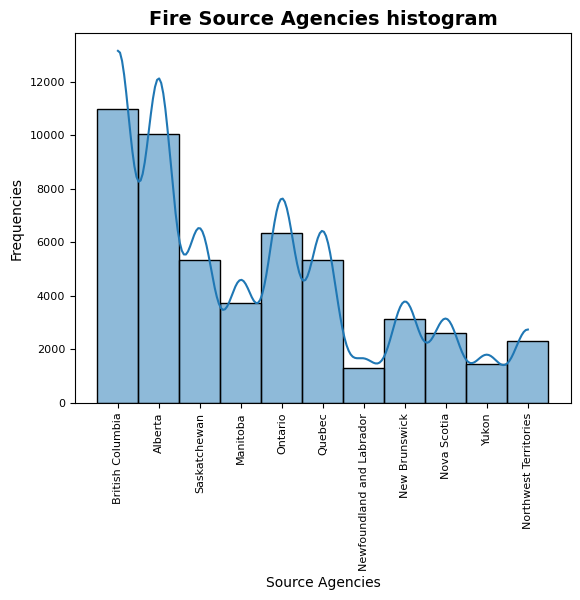

In [28]:
sns.histplot(df_filtered['src_agency'], kde = True ) # shows extreme values for 'src_agency'
plt.title("Fire Source Agencies histogram", fontsize = 14, fontweight="bold")
plt.xticks(rotation = 'vertical', fontsize = 8)
plt.yticks(fontsize = 8)
plt.xlabel('Source Agencies')
plt.ylabel('Frequencies')

Text(0, 0.5, 'Frequencies')

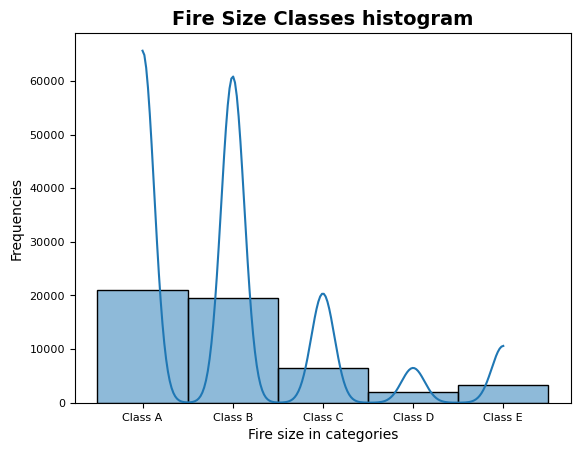

In [29]:
sns.histplot(df_filtered['size_class'], kde = True ) # shows extreme values for 'size_class'
plt.title("Fire Size Classes histogram", fontsize = 14, fontweight="bold")
plt.yticks(fontsize = 8)
plt.xticks(fontsize = 8)
plt.xlabel('Fire size in categories')
plt.ylabel('Frequencies')

Text(0, 0.5, 'Frequencies')

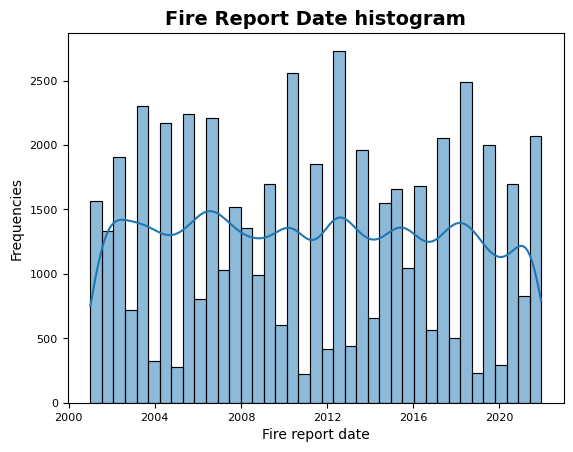

In [30]:
sns.histplot(df_filtered['rep_date'], kde = True ) # shows extreme values for 'rep_date'
plt.title("Fire Report Date histogram", fontsize = 14, fontweight="bold")
plt.yticks(fontsize = 8)
plt.xticks(fontsize = 8)
plt.xlabel('Fire report date')
plt.ylabel('Frequencies')

Text(0, 0.5, 'Frequencies')

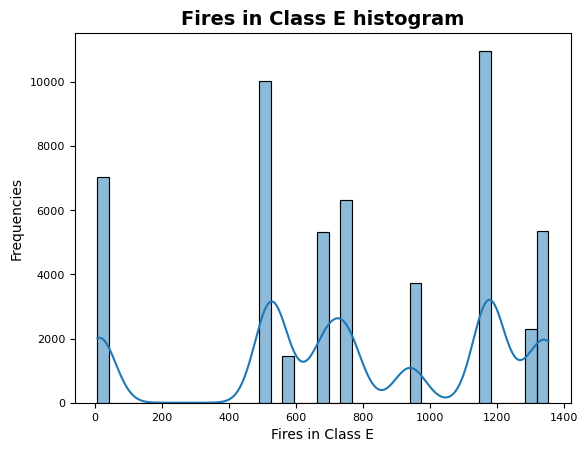

In [31]:
sns.histplot(df_filtered['count_E_class'], kde = True ) # shows extreme values for 'number of fires in class E'
plt.title("Fires in Class E histogram", fontsize = 14, fontweight="bold")
plt.yticks(fontsize = 8)
plt.xticks(fontsize = 8)
plt.xlabel('Fires in Class E')
plt.ylabel('Frequencies')

In [32]:
# Select only entries with a non-zero Class Es

df_filtered = df_filtered[df_filtered['count_E_class'] > 0]
df_filtered.shape

(52562, 6)

### 4. Plotting a choropleth
** **

In [33]:
# Selecting the data needed for ploting

data_to_plot = df_filtered[['src_agency', 'count_E_class']].drop_duplicates()
data_to_plot

,src_agency,count_E_class
fire_id,,
105315,British Columbia,1177
172655,Alberta,523
212118,Saskatchewan,1354
237404,Manitoba,941
264912,Ontario,753
328420,Quebec,685
371544,Newfoundland and Labrador,26
375916,New Brunswick,7
386958,Nova Scotia,15


In [34]:
# Setup a folium map at a high-level zoom
map = folium.Map( title = 'Count of large fires (> 121 hectares) in Canadian provinces between 2001 and 2021', location = [59.400000,-110.639500], zoom_start = 3)

# Choropleth maps bind Pandas Data Frames and json geometries.This allows us to quickly visualize data combinations
folium.Choropleth(
    geo_data = country_geo, 
    data = data_to_plot,
    columns = ['src_agency', 'count_E_class'],
    key_on = 'feature.properties.prov_name', # this part is very important - check your json file to see where the KEY is located
    fill_color = 'YlOrBr', fill_opacity=0.6, line_opacity=0.1,
    legend_name = "Class E fires").add_to(map)
folium.LayerControl().add_to(map)

map

#### Result:

This map represents the number of large fires (Class E: > 121 hectares) in the last 20 years (2001-2021). The darker the shading, the larger number of fires in a province. You can see from choropleth map that the overall number of large fires in Canadian provinces is pretty high aside from a few provinces shaded in lighter yellow, with the least number of Class E fires in New Brunswick in the last 20 years. Judging by its color and comparing it to the legend, the number would be around 7 fires. However, the provinces having the highest number of Class E fires seem to be Saskatchewan, Northwest Territories, and British Columbia which are shaded in brown.

##### New Research Question:

Does the number of wildfires stays the same in Canadian provinces over the years?

### 5. Exporting the last updated dataframe in .pkl format
** **

In [35]:
# Exporting the last version of datafram with new columns

df_fires.to_pickle(os.path.join(path, '02 Data', 'Prepared Data', 'updated_wildfires.pkl'))
df_fires.to_csv(os.path.join(path, '02 Data', 'Prepared Data', 'provinces_wildfires.csv'))

In [36]:
# Saving map in .html format
map.save('plot_data.html')